# Medical Segmentation of Brain Tumor MRI Images
## EE 621 Computer Vision

#### BY AVI KHANDELWAL (204102301), SATYAKI GHOSH (204102311)

### 1. Importing packages

In [1]:
import cv2
import h5py
import imageio
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Image
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.compat.v1.logging import INFO, set_verbosity

set_verbosity(INFO)

import json
import pandas as pd
import nibabel as nib

import tensorflow.python.keras.backend as K
K.set_image_data_format("channels_first")

### 2. Utility functions

In [2]:
#  Visualising image
def plot_image_grid(image):
    data_all = []

    data_all.append(image)

    fig, ax = plt.subplots(3, 6, figsize=[16, 9])

    coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
    #Hello
    coronal = np.rot90(coronal, 1)

    # transversal plane
    transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
    transversal = np.rot90(transversal, 2)

    # sagittal plane
    sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
    sagittal = np.rot90(sagittal, 1)

    for i in range(6):
        n = np.random.randint(coronal.shape[2])
        ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        if i == 0:
            ax[0][i].set_ylabel('Coronal', fontsize=15)

    for i in range(6):
        n = np.random.randint(transversal.shape[2])
        ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        if i == 0:
            ax[1][i].set_ylabel('Transversal', fontsize=15)

    for i in range(6):
        n = np.random.randint(sagittal.shape[2])
        ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        if i == 0:
            ax[2][i].set_ylabel('Sagittal', fontsize=15)

    fig.subplots_adjust(wspace=0, hspace=0)


# Creating convolutional block
def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):

    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)

# Defining upconvolution
def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Deconvolution3D(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

# Defining the 3D unet model
def unet_model_3d(loss_function, input_shape=(4, 160, 160, 16),
                  pool_size=(2, 2, 2), n_labels=3,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=4, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
  
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])
    for layer_depth in range(depth - 2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size,
                                    deconvolution=deconvolution,
                                    n_filters=
                                    current_layer.shape[1])(
    current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        current_layer = create_convolution_block(
        n_filters=levels[layer_depth][1].shape[1],
        input_layer=concat, batch_normalization=batch_normalization)
        current_layer = create_convolution_block(
        n_filters=levels[layer_depth][1].shape[1],
        input_layer=current_layer,
        batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model

# Visualising the output patch
def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)


class VolumeDataGenerator(keras.utils.Sequence):
    def __init__(self,
                 sample_list,
                 base_dir,
                 batch_size=1,
                 shuffle=True,
                 dim=(160, 160, 16),
                 num_channels=4,
                 num_classes=3,
                 verbose=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = sample_list
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.sample_list) / self.batch_size))

    def __data_generation(self, list_IDs_temp):

        # Initialization
        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float64)
        y = np.zeros((self.batch_size, self.num_classes, *self.dim),
                     dtype=np.float64)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.verbose == 1:
                print("Training on: %s" % self.base_dir + ID)
            with h5py.File(self.base_dir + ID, 'r') as f:
                X[i] = np.array(f.get("x"))
                # remove the background class
                y[i] = np.moveaxis(np.array(f.get("y")), 3, 0)[1:]
        return X, y

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)

        return X, y

# Finding out the labels of the input image
def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)

    labeled_image = np.zeros_like(label[:, :, :, 1:])

    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image

# Predicting the tumerous region and visualising the output
def predict_and_viz(image, label, model, threshold, loc=(100, 100, 50)):
    image_labeled = get_labeled_image(image.copy(), label.copy())

    model_label = np.zeros([3, 320, 320, 160])

    for x in range(0, image.shape[0], 160):
        for y in range(0, image.shape[1], 160):
            for z in range(0, image.shape[2], 16):
                patch = np.zeros([4, 160, 160, 16])
                p = np.moveaxis(image[x: x + 160, y: y + 160, z:z + 16], 3, 0)
                patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p
                pred = model.predict(np.expand_dims(patch, 0))
                model_label[:, x:x + p.shape[1],
                y:y + p.shape[2],
                z: z + p.shape[3]] += pred[0][:, :p.shape[1], :p.shape[2],
                                      :p.shape[3]]

    model_label = np.moveaxis(model_label[:, 0:240, 0:240, 0:155], 0, 3)
    model_label_reformatted = np.zeros((240, 240, 155, 4))

    model_label_reformatted = to_categorical(label, num_classes=4).astype(
        np.uint8)

    model_label_reformatted[:, :, :, 1:4] = model_label

    model_labeled_image = get_labeled_image(image, model_label_reformatted,
                                            is_categorical=True)

    fig, ax = plt.subplots(2, 3, figsize=[10, 7])

    # plane values
    x, y, z = loc

    ax[0][0].imshow(np.rot90(image_labeled[x, :, :, :]))
    ax[0][0].set_ylabel('Ground Truth', fontsize=15)
    ax[0][0].set_xlabel('Sagital', fontsize=15)

    ax[0][1].imshow(np.rot90(image_labeled[:, y, :, :]))
    ax[0][1].set_xlabel('Coronal', fontsize=15)

    ax[0][2].imshow(np.squeeze(image_labeled[:, :, z, :]))
    ax[0][2].set_xlabel('Transversal', fontsize=15)

    ax[1][0].imshow(np.rot90(model_labeled_image[x, :, :, :]))
    ax[1][0].set_ylabel('Prediction', fontsize=15)

    ax[1][1].imshow(np.rot90(model_labeled_image[:, y, :, :]))
    ax[1][2].imshow(model_labeled_image[:, :, z, :])

    fig.subplots_adjust(wspace=0, hspace=.12)

    for i in range(2):
        for j in range(3):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])

    return model_label_reformatted


### 3. Data Exploration

In [3]:
# Loading image file
HOME_DIR = "/content/drive/MyDrive/Task01_BrainTumour/"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


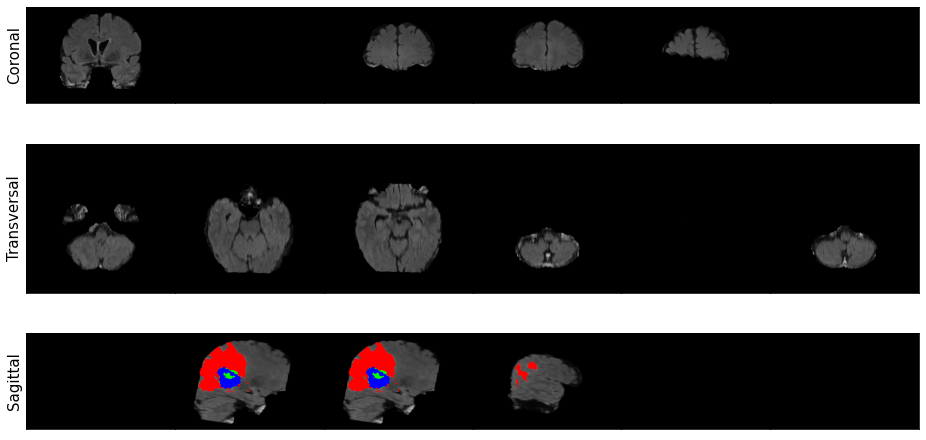

In [5]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
image = get_labeled_image(image, label)

plot_image_grid(image)

In [6]:
# Getting a sub-volume from the image data
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
  
    X = None
    y = None
    
    tries = 0
    
    while tries < max_tries:
   
        start_x = np.random.randint(0, orig_x - output_x+1)
        start_y = np.random.randint(0, orig_y - output_y+1)
        start_z = np.random.randint(0, orig_z - output_z+1)

        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        bgrd_ratio = np.sum(y[:, :, :, 0])/(output_x * output_y * output_z)

        tries += 1

        if bgrd_ratio < background_threshold:

            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            X = np.moveaxis(X, 3, 0)
            y = np.moveaxis(y, 3, 0)
            y = y[1:, :, :, :]
    
            return X, y

    print(f"Tried {tries} times to find a sub-volume. Giving up...")

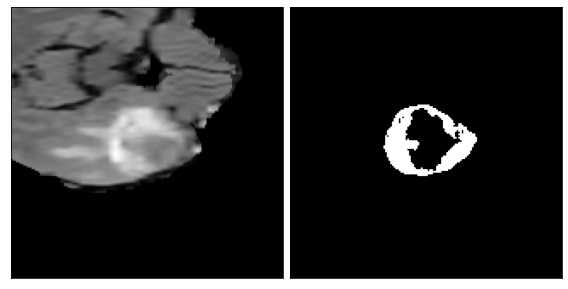

In [7]:
#segmenting the tumerous region of the patch
image, label = load_case(DATA_DIR + "imagesTr/BRATS_001.nii.gz", DATA_DIR + "labelsTr/BRATS_001.nii.gz")
X, y = get_sub_volume(image, label)
visualize_patch(X[0, :, :, :], y[2])
# y[0] -> edemas
# y[1] -> non-enhancing tumors
# y[2] -> enhancing tumors

### 4. Constructing U-net model 

In [8]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
   
    
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))

    return dice_coefficient

def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))

    return dice_loss

In [9]:
model = unet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [10]:
base_dir = HOME_DIR + "processed/"
with open("/content/drive/MyDrive/dataset.json") as json_file:
    config = json.load(json_file)
train_generator = VolumeDataGenerator(config["training"], base_dir + "train/", batch_size=3, dim=(160, 160, 16), verbose=0)
valid_generator = VolumeDataGenerator(config["test"], base_dir + "valid/", batch_size=3, dim=(160, 160, 16), verbose=0)

In [11]:
model.load_weights(HOME_DIR + "model_pretrained.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 160, 160, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 160, 160, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 160, 160, 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 160, 160, 55360       activation[0][0]                 
______________________________________________________________________________________________

### 6. Patch wise predictions

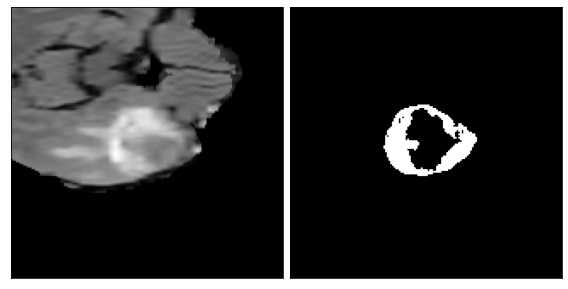

In [12]:
visualize_patch(X[0, :, :, :], y[2])
X_with_batch_dimension = np.expand_dims(X, axis=0)
patch_pred = model.predict(X_with_batch_dimension)

Patch and ground truth


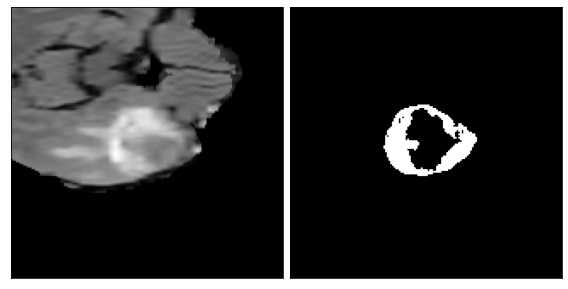

Patch and prediction


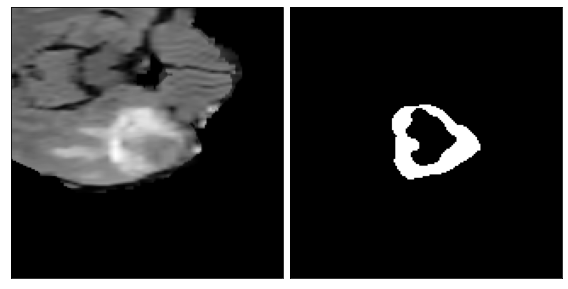

In [19]:
threshold = 0.5

patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.0

print("Patch and ground truth")
visualize_patch(X[0, :, :, :], y[2])
plt.show()

print("Patch and prediction")
visualize_patch(X[0, :, :, :], patch_pred[0, 2, :, :, :])
plt.show()

### 7. Evaluation metrics 

In [20]:
def compute_class_sens_spec(pred, label, class_num):
    class_pred = pred[class_num]
    class_label = label[class_num]

    tp = np.sum((class_pred == 1) & (class_label == 1))
    tn = np.sum((class_pred == 0) & (class_label == 1))
    fp = np.sum((class_pred == 1) & (class_label == 0))
    fn = np.sum((class_pred == 0) & (class_label == 0))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return sensitivity, specificity

def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [21]:
# Evaluating for the given patch
sensitivity, specificity = compute_class_sens_spec(patch_pred[0], y, 2)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\n")
df = get_sens_spec_df(patch_pred[0], y)

Sensitivity: 0.0253
Specificity: 0.4741




### 8. Results on test case

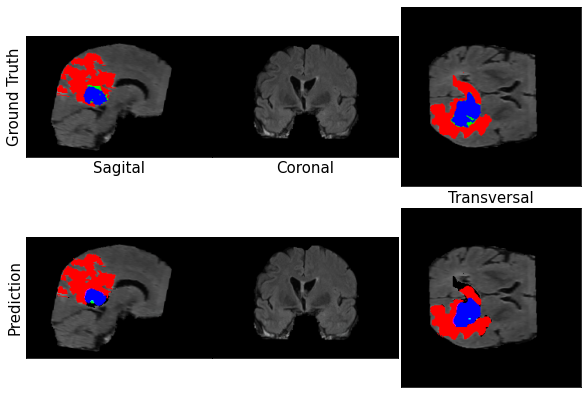

In [22]:
image, label = load_case(DATA_DIR + "imagesTr/BRATS_003.nii.gz", DATA_DIR + "labelsTr/BRATS_003.nii.gz")
pred = predict_and_viz(image, label, model, .5, loc=(130, 130, 77))      

In [23]:
# Evaluation metrics
whole_scan_label = keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]
whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)

              Edema Non-Enhancing Tumor Enhancing Tumor
Sensitivity  0.0152              0.0001           0.002
Specificity  0.1346              0.6627          0.1687


In [24]:
for key, value in config.items():
    #print("Key:")
    print(key)

name
description
reference
licence
release
tensorImageSize
modality
labels
numTraining
numTest
training
test
